# Import Libraries and Datasets; Adjust Datasets to Reflect Households in Bihar

In [138]:
!pip install eep153_tools
!pip install -r requirements.txt

In [139]:
!pip install pyarrow

In [140]:
import cfe
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [141]:
z =  pd.read_parquet('z.parquet', engine = 'pyarrow')

In [142]:
#q =  pd.read_parquet('q.parquet', engine = 'pyarrow').unstack('j')
q = pd.read_parquet('q.parquet', engine = 'pyarrow').reset_index()
q

,j,i,unit,Frequency,total_quantity
0,410001101,apple,kg,Monthly,250.0
1,410001101,arhar (tur),kg,Monthly,2000.0
2,410001101,besan,kg,Monthly,2000.0
3,410001101,black pepper,gm,Monthly,20.0
4,410001101,brinjal,kg,Monthly,5000.0
...,...,...,...,...,...
4423639,799982301,tomato,kg,Monthly,3000.0
4423640,799982301,turmeric,gm,Monthly,300.0
4423641,799982301,urd,kg,Monthly,1000.0
4423642,799982301,wheat/atta - P.D.S.,kg,Monthly,10000.0


In [143]:
q['total_quantity'].mask(q['unit'] == 'kg', q['total_quantity'] / 1000, inplace=True)
q['total_quantity'].mask(q['unit'] == 'litre', q['total_quantity'] / 1000, inplace=True)
q

,j,i,unit,Frequency,total_quantity
0,410001101,apple,kg,Monthly,0.25
1,410001101,arhar (tur),kg,Monthly,2.00
2,410001101,besan,kg,Monthly,2.00
3,410001101,black pepper,gm,Monthly,20.00
4,410001101,brinjal,kg,Monthly,5.00
...,...,...,...,...,...
4423639,799982301,tomato,kg,Monthly,3.00
4423640,799982301,turmeric,gm,Monthly,300.00
4423641,799982301,urd,kg,Monthly,1.00
4423642,799982301,wheat/atta - P.D.S.,kg,Monthly,10.00


We also need to make sure that we only include households in Bihar, so we filter out households in other states below.

In [144]:
z_bihar = z[z['m'] == 'Bihar']
bihar_households = z_bihar.index
q_bihar2 = q[q['j'].isin(bihar_households)]
q_bihar2
#q_adjusted = q.T.reset_index()
#q_bihar = q_adjusted[q_adjusted['j'].isin(bihar_households)]
#q_bihar

,j,i,unit,Frequency,total_quantity
1335859,470441101,arhar (tur),kg,Monthly,2.50
1335860,470441101,"biscuits, chocolates",Re,Monthly,0.00
1335861,470441101,black pepper,gm,Monthly,100.00
1335862,470441101,"cake, pastry, prepared sweets",Re,Monthly,0.00
1335863,470441101,cashewnut,kg,Monthly,0.25
...,...,...,...,...,...
3155891,746992301,tea : cups,no.,Monthly,10.00
3155892,746992301,tea : leaf,gm,Monthly,100.00
3155893,746992301,tomato,kg,Monthly,2.00
3155894,746992301,turmeric,gm,Monthly,450.00


In [145]:
x = pd.read_parquet('x.parquet', engine = 'pyarrow').unstack('j')

In [146]:
x_adjusted = x.T.reset_index()
x_bihar = x_adjusted[x_adjusted['j'].isin(bihar_households)]

In [147]:
n =  pd.read_parquet('n.parquet', engine = 'pyarrow')
n = n.rename(columns={'calories per unit(kcal)': 'Calories', 'fat per unit(gm)': 'Fat', 'protein per unit(gm)': 'Protein'})
n

,Calories,Fat,i,Protein,rural,t,unit
1,3280.000000,13.00,ragi,73.00,NaN,50,kg
4,1100.000000,2.00,other cereal subs.,16.00,NaN,50,kg
5,3420.000000,36.00,maize-other sources,111.00,NaN,50,kg
7,3420.000000,36.00,maize - pds,111.00,NaN,50,kg
8,3360.000000,13.00,barley,115.00,NaN,50,kg
...,...,...,...,...,...,...,...
145,24.700001,0.95,other served processed food,0.70,0.0,68,Re
146,21.100000,0.85,"cake, pastry, prepared sweets",0.20,0.0,68,Re
147,28.500000,0.17,"biscuits, chocolates",0.35,0.0,68,Re
148,24.700001,0.95,"papad, bhujia, namkeen, mixture, chanachur",0.70,0.0,68,Re


In [148]:
#n['Fat'].mask(n['unit'] == 'kg', n['Fat'] / 1000, inplace=True)
#n['Protein'].mask(n['unit'] == 'kg', n['Protein'] / 1000, inplace=True)
#n['Calories'].mask(n['unit'] == 'kg', n['Fat'] / 1000, inplace=True)
#n

In [149]:
total_expenditures =  pd.read_parquet('total_expenditures.parquet', engine = 'pyarrow')

# Import RDA Data and Mapping RDA to Households in Bihar
RDA is a dataframe indicating the recommended daily allowances in India. As we see below, RDA includes different age/sex groups and ranges than what we see in our household data. So, we created a dataframe, rda_fixed, that shows the recommended daily allowances in India corresponding to the age/sex categories in the datasets we imported above.

In [150]:
rda = pd.read_pickle('indian_rda.df').T 
rda = rda.replace('', np.nan)
rda

,C 0-0.5,C 0.5-1,C 1-3,C 4-6,C 7-9,B 10-12,G 10-12,B 13-15,G 13-15,B 16-17,G 16-17,M,W
Calories,NaN,NaN,1060.0,1350.0,1690.0,2190.0,2010.0,2750.0,2330.0,3020.0,2440.0,2730.0,2230.0
Protein,NaN,NaN,16.7,20.1,29.5,39.9,40.4,54.3,51.9,61.5,55.5,60.0,55.0
Fat,NaN,19.0,27.0,25.0,30.0,35.0,35.0,45.0,40.0,50.0,35.0,30.0,25.0
Calcium,500.0,500.0,600.0,600.0,600.0,800.0,800.0,800.0,800.0,800.0,800.0,600.0,1200.0
Iron,NaN,5.0,9.0,13.0,16.0,21.0,27.0,32.0,27.0,28.0,26.0,17.0,21.0
Betacarotene,NaN,2800.0,3200.0,3200.0,4800.0,4800.0,4800.0,4800.0,4800.0,4800.0,4800.0,4800.0,4800.0
Thiamine,0.2,0.3,0.5,0.7,0.8,1.1,1.0,1.4,1.2,1.5,1.0,1.4,1.1
Riboflavin,0.3,0.4,0.6,0.8,1.0,1.3,1.2,1.6,1.4,1.8,1.2,1.4,1.3
Niacin,NaN,NaN,8.0,11.0,13.0,15.0,13.0,16.0,14.0,17.0,14.0,18.0,14.0
Ascorbic Acid,25.0,25.0,40.0,40.0,40.0,40.0,40.0,40.0,40.0,40.0,40.0,40.0,40.0


In [151]:
rda_fixed = pd.DataFrame(index = rda.index)
rda_fixed['Males 60-100'] = rda['M'].to_list()
rda_fixed['Males 50-60'] = rda['M'].to_list()
rda_fixed['Males 30-50'] = rda['M'].to_list()
rda_fixed['Males 20-30'] = rda['M'].to_list()
rda_fixed['Males 15-20'] = (np.array(rda['M']) + np.array(rda['B 16-17'])) / 2
rda_fixed['Males 10-15'] = (np.array(rda['B 10-12']) + np.array(rda['B 13-15'])) / 2
rda_fixed['Males 5-10'] = (np.array(rda['C 4-6']) + np.array(rda['C 7-9'])) / 2
rda_fixed['Males 1-5'] = (np.array(rda['C 1-3']) + np.array(rda['C 4-6'])) / 2
rda_fixed['Males 0-1'] = (np.array(rda['C 0-0.5']) + np.array(rda['C 0.5-1'])) / 2
rda_fixed['Females 60-100'] = rda['W'].to_list()
rda_fixed['Females 50-60'] = rda['W'].to_list()
rda_fixed['Females 30-50'] = rda['W'].to_list()
rda_fixed['Females 20-30'] = rda['W'].to_list()
rda_fixed['Females 15-20'] = (np.array(rda['W']) + np.array(rda['G 16-17'])) / 2
rda_fixed['Females 10-15'] = (np.array(rda['G 10-12']) + np.array(rda['G 13-15'])) / 2
rda_fixed['Females 5-10'] = (np.array(rda['C 4-6']) + np.array(rda['C 7-9'])) / 2
rda_fixed['Females 1-5'] = (np.array(rda['C 1-3']) + np.array(rda['C 4-6'])) / 2
rda_fixed['Females 0-1'] = (np.array(rda['C 0-0.5']) + np.array(rda['C 0.5-1'])) / 2
rda_fixed

,Males 60-100,Males 50-60,Males 30-50,Males 20-30,Males 15-20,Males 10-15,Males 5-10,Males 1-5,Males 0-1,Females 60-100,Females 50-60,Females 30-50,Females 20-30,Females 15-20,Females 10-15,Females 5-10,Females 1-5,Females 0-1
Calories,2730.0,2730.0,2730.0,2730.0,2875.00,2470.00,1520.00,1205.0,NaN,2230.0,2230.0,2230.0,2230.0,2335.00,2170.00,1520.00,1205.0,NaN
Protein,60.0,60.0,60.0,60.0,60.75,47.10,24.80,18.4,NaN,55.0,55.0,55.0,55.0,55.25,46.15,24.80,18.4,NaN
Fat,30.0,30.0,30.0,30.0,40.00,40.00,27.50,26.0,NaN,25.0,25.0,25.0,25.0,30.00,37.50,27.50,26.0,NaN
Calcium,600.0,600.0,600.0,600.0,700.00,800.00,600.00,600.0,500.00,1200.0,1200.0,1200.0,1200.0,1000.00,800.00,600.00,600.0,500.00
Iron,17.0,17.0,17.0,17.0,22.50,26.50,14.50,11.0,NaN,21.0,21.0,21.0,21.0,23.50,27.00,14.50,11.0,NaN
Betacarotene,4800.0,4800.0,4800.0,4800.0,4800.00,4800.00,4000.00,3200.0,NaN,4800.0,4800.0,4800.0,4800.0,4800.00,4800.00,4000.00,3200.0,NaN
Thiamine,1.4,1.4,1.4,1.4,1.45,1.25,0.75,0.6,0.25,1.1,1.1,1.1,1.1,1.05,1.10,0.75,0.6,0.25
Riboflavin,1.4,1.4,1.4,1.4,1.60,1.45,0.90,0.7,0.35,1.3,1.3,1.3,1.3,1.25,1.30,0.90,0.7,0.35
Niacin,18.0,18.0,18.0,18.0,17.50,15.50,12.00,9.5,NaN,14.0,14.0,14.0,14.0,14.00,13.50,12.00,9.5,NaN
Ascorbic Acid,40.0,40.0,40.0,40.0,40.00,40.00,40.00,40.0,25.00,40.0,40.0,40.0,40.0,40.00,40.00,40.00,40.0,25.00


Now that we have a dataframe detailing the recommended daily intakes with the same age/sex groups as our imported dataset, we want to do a matrix multiplication of this dataframe and z_bihar_ages, which tells us how many people are in each age/sex group per household.

In [152]:
z_bihar_ages = z_bihar.iloc[:, 4:]
z_bihar_ages.to_numpy()

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 1, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 2, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 1, 0, 0]])

In [153]:
transposed_rda = rda_fixed.reset_index().rename(columns={'index': 'Nutrition'}).drop(['Nutrition'], axis=1).T
transposed_rda = transposed_rda.to_numpy()
transposed_rda

array([[2.730e+03, 6.000e+01, 3.000e+01, 6.000e+02, 1.700e+01, 4.800e+03,
        1.400e+00, 1.400e+00, 1.800e+01, 4.000e+01],
       [2.730e+03, 6.000e+01, 3.000e+01, 6.000e+02, 1.700e+01, 4.800e+03,
        1.400e+00, 1.400e+00, 1.800e+01, 4.000e+01],
       [2.730e+03, 6.000e+01, 3.000e+01, 6.000e+02, 1.700e+01, 4.800e+03,
        1.400e+00, 1.400e+00, 1.800e+01, 4.000e+01],
       [2.730e+03, 6.000e+01, 3.000e+01, 6.000e+02, 1.700e+01, 4.800e+03,
        1.400e+00, 1.400e+00, 1.800e+01, 4.000e+01],
       [2.875e+03, 6.075e+01, 4.000e+01, 7.000e+02, 2.250e+01, 4.800e+03,
        1.450e+00, 1.600e+00, 1.750e+01, 4.000e+01],
       [2.470e+03, 4.710e+01, 4.000e+01, 8.000e+02, 2.650e+01, 4.800e+03,
        1.250e+00, 1.450e+00, 1.550e+01, 4.000e+01],
       [1.520e+03, 2.480e+01, 2.750e+01, 6.000e+02, 1.450e+01, 4.000e+03,
        7.500e-01, 9.000e-01, 1.200e+01, 4.000e+01],
       [1.205e+03, 1.840e+01, 2.600e+01, 6.000e+02, 1.100e+01, 3.200e+03,
        6.000e-01, 7.000e-01, 9.500e+

nutrition_by_house is a dataframe that tells us the recommended daily allowances per household, based on the specific individuals in that household (i.e. their ages, how many people there are, etc). 

In [154]:
nutrition_by_house = z_bihar_ages.dot(transposed_rda)
nutrition_by_house.columns = rda_fixed.index
#nutrition_by_house['Household'] = maharashtra_id
#nutrition_by_house.index = nutrition_by_house['Household']
nutrition_by_house

,Calories,Protein,Fat,Calcium,Iron,Betacarotene,Thiamine,Riboflavin,Niacin,Ascorbic Acid
j,,,,,,,,,,
470441101,NaN,NaN,NaN,1900.0,NaN,NaN,2.80,3.20,NaN,120.0
470441102,NaN,NaN,NaN,2300.0,NaN,NaN,3.95,4.50,NaN,120.0
470441201,NaN,NaN,NaN,5500.0,NaN,NaN,7.95,8.80,NaN,280.0
470441202,NaN,NaN,NaN,3000.0,NaN,NaN,5.70,6.00,NaN,200.0
470441203,NaN,NaN,NaN,3800.0,NaN,NaN,4.75,5.55,NaN,200.0
...,...,...,...,...,...,...,...,...,...,...
746991301,NaN,NaN,NaN,2700.0,NaN,NaN,3.90,4.45,NaN,160.0
746992101,NaN,NaN,NaN,5300.0,NaN,NaN,5.05,6.05,NaN,225.0
746992201,NaN,NaN,NaN,5900.0,NaN,NaN,7.10,8.30,NaN,280.0


Next, we then merged our nutrient dataset and q_bihar to create q_bihar_n, which describes the total_quantity, calorie, fat per unit, and protein per unit intake for each food item in each household.

In [155]:
q_bihar_n = q_bihar2.merge(n, left_on='i', right_on='i')
q_bihar_n['total_quantity'] = q_bihar_n['total_quantity']
q_bihar_n

,j,i,unit_x,Frequency,total_quantity,Calories,Fat,Protein,rural,t,unit_y
0,470441101,arhar (tur),kg,Monthly,2.5,3350.0,17.0,223.0,0.0,68,kg
1,470441102,arhar (tur),kg,Monthly,1.0,3350.0,17.0,223.0,0.0,68,kg
2,470441201,arhar (tur),kg,Monthly,3.0,3350.0,17.0,223.0,0.0,68,kg
3,470441203,arhar (tur),kg,Monthly,2.0,3350.0,17.0,223.0,0.0,68,kg
4,470441204,arhar (tur),kg,Monthly,1.0,3350.0,17.0,223.0,0.0,68,kg
...,...,...,...,...,...,...,...,...,...,...,...
217323,745712101,small millets & products,kg,Monthly,3.0,2615.0,34.0,97.0,0.0,68,kg
217324,745712202,small millets & products,kg,Monthly,2.0,2615.0,34.0,97.0,0.0,68,kg
217325,745712301,small millets & products,kg,Monthly,2.0,2615.0,34.0,97.0,0.0,68,kg
217326,743292101,jowar & products,kg,Monthly,2.0,3490.0,19.0,104.0,0.0,68,kg


# Nutritional Adequacy of Food Demands

zbar is the proportion of households in Bihar that have each of the age/sex groups shown below.

In [156]:
zbar = z_bihar.mean(axis=0)
zbar

/tmp/ipykernel_24/1843868859.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  zbar = z_bihar.mean(axis=0)


k
Males 0-1         0.028154
Males 1-5         0.235050
Males 5-10        0.352248
Males 10-15       0.370581
Males 15-20       0.328677
Males 20-30       0.442165
Males 30-50       0.661502
Males 50-60       0.192056
Males 60-100      0.202750
Females 0-1       0.023352
Females 1-5       0.211698
Females 5-10      0.300087
Females 10-15     0.299651
Females 15-20     0.225011
Females 20-30     0.401571
Females 30-50     0.634221
Females 50-60     0.181580
Females 60-100    0.150153
dtype: float64

Now, the inner/dot/matrix product between zbar and the rda_fixed DataFrame of requirements will give us minimum requirements for the average household:

In [157]:
# May need to tweak types or alignment to match RDA and zbar types:
rda0,zbar0=rda_fixed.align(zbar,axis=1) #this method allows us to align columns if there's a different order 

# This matrix product gives minimum nutrient requirements for average
hh_rda = rda0.replace(np.nan,0)@zbar0
# RDA is /daily/, but  demands in ICRISAT data are /monthly/:
hh_rda = hh_rda #household level of RDA, multiplied by 30 because we have them at monthly level
hh_rda #in millions of calories bc it's for all people in household over a year 

Calories         11706.215626
Protein            253.202532
Fat                154.654518
Calcium           4216.586643
Iron                99.159101
Betacarotene     23670.536883
Thiamine             5.878001
Riboflavin           6.527532
Niacin              76.881275
Ascorbic Acid      208.847665
dtype: float64

In [158]:
r = cfe.result.from_dataset('bihar.ds',engine='netcdf4')
UseNutrients=['Protein','Calories','Fat']

# Reference period, market
t,m = 1,1 

# Reference budget (find mean in reference period & market):
reference_x = r.get_predicted_expenditures().mean('j').sum('i').sel(m=m)

p = r.prices.sel(m=m,drop=True)
p = p.to_dataframe('i').squeeze().dropna()
p.index = p.index.droplevel()
p

i
apple                                               0.075035
arhar (tur)                                         0.075512
besan                                               0.060223
bread (bakery)                                      0.049760
brinjal                                             0.014824
cabbage                                             0.010304
cauliflower                                         0.012188
chicken                                             0.121698
chillis (green)                                     0.046695
chira                                               0.024698
firewood & chips                                    0.005032
fish ( fresh )                                      0.107222
french beans and barbati                            0.018852
goat meat                                           0.256172
gourd, pumpkin                                      0.009991
gram (split)                                        0.055219
gram (whole)          

In [159]:
n = n.set_index('i').drop(['rural', 't', 'unit'], axis=1)
n = n[n.index.isin(p.index)]
#n = n.drop(labels=['peas-vegetables'])
n

,Calories,Fat,Protein
i,,,
potato,970.0,1.0,16.0
rice - P.D.S.,3460.0,5.0,75.0
rice - other sources,3460.0,5.0,75.0
chira,3460.0,12.0,66.0
muri,3250.0,1.0,75.0
wheat/atta - P.D.S.,3410.0,17.0,121.0
wheat/atta - other sources,3410.0,17.0,121.0
maida,3480.0,9.0,110.0
"suji, rawa",3480.0,8.0,104.0


In [160]:
def my_prices(p0,p=p,i='Coconut'): #utility function
    p = p.copy()
    p.loc[i] = p0
    return p

In [161]:
p = p.drop(labels=['firewood & chips', 'lpg'])
p = p.drop(labels=['salt ', 'peas-vegetables'])

In [162]:
n = n.drop(labels=['peas-vegetables'])

In [163]:
len(n.index), len(p.index) #sanity check, make sure that items in p and n are the same -- important to generating our plots!

(42, 42)

In [164]:
import warnings 

def nutrient_demand(x,p): 
    with warnings.catch_warnings(): #gets rids of messy warnings
        warnings.simplefilter("ignore")
        c = r.demands(x,p) #compute quantities demand for all food

    n0,c0 = n.align(c,axis=0,join='inner') #alignment trick
    
    N = n0.T@c0 #takes quantities demand (c0) and multiplies by fct0

    N = N.loc[~N.index.duplicated()]
    
    return N/7

Text(0, 0.5, 'log nutrient')

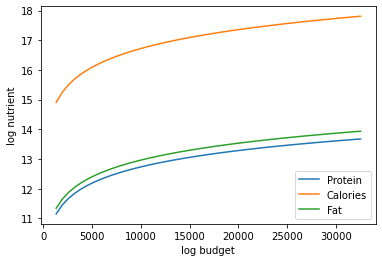

In [165]:
import numpy as np
import matplotlib.pyplot as plt

X = np.linspace(reference_x/5,reference_x*5,50)
X = X.flatten()

UseNutrients = ['Protein','Calories','Fat']

df = pd.concat({myx:np.log(nutrient_demand(myx,p))[UseNutrients] for myx in X},axis=1).T
ax = df.plot()

ax.set_xlabel('log budget') 
ax.set_ylabel('log nutrient')

In [216]:
r.get_beta(as_df=True).sort_values() # this allows us to see which goods are the most elastic/inelastic

i
maize & products                             -0.058078
kerosene-pds                                 -0.014995
rice - P.D.S.                                 0.017503
matches                                       0.030918
wheat/atta - P.D.S.                           0.036592
                                                ...   
papad, bhujia, namkeen, mixture, chanachur    0.455317
orange,mausami                                0.456468
other fresh fruits                            0.474922
apple                                         0.505788
cake, pastry, prepared sweets                 0.520278
Name: beta, Length: 82, dtype: float64

Text(0, 0.5, 'log nutrient')

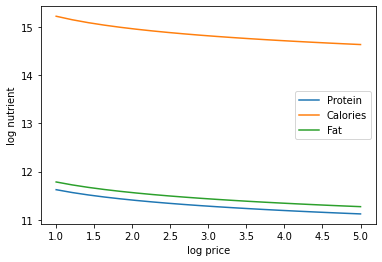

In [167]:
USE_GOOD = "apple"

ref_price = r.prices.sel(i=USE_GOOD,m=m,drop=True)

P = np.linspace(1,5,20).tolist()

ndf = pd.DataFrame({p0:np.log(nutrient_demand(reference_x,my_prices(p0,i=USE_GOOD)))[UseNutrients] for p0 in P}).T

ax = ndf.plot()

ax.set_xlabel('log price')
ax.set_ylabel('log nutrient') 

Text(0, 0.5, 'log nutrient')

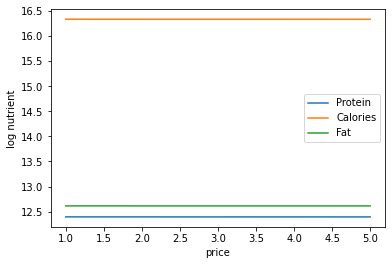

In [168]:
USE_GOOD = "rice - P.D.S."

ref_price = r.prices.sel(i=USE_GOOD,m=m,drop=True)

P = np.linspace(1,5,20).tolist()

ndf = pd.DataFrame({p0:np.log(nutrient_demand(reference_x,my_prices(p0,i=USE_GOOD)))[UseNutrients] for p0 in P}).T

ax = ndf.plot()

ax.set_xlabel('price')
ax.set_ylabel('log nutrient') 

In [169]:
def nutrient_adequacy_ratio(x,p):
    return nutrient_demand(x,p)/hh_rda #greater than 1 = adequate, less than 1 = less than adequate bc log of ratios

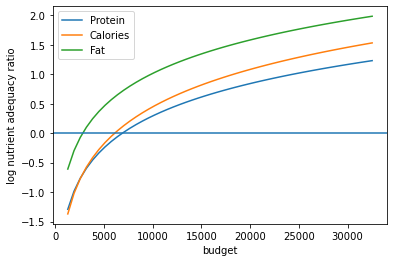

In [170]:
X = np.linspace(reference_x/5,reference_x*5,50)
X = X.flatten()
ndf = pd.concat({x:np.log(nutrient_adequacy_ratio(x,p))[UseNutrients] for x in X},axis=1).T

ax = (ndf-np.log(1000)).plot()

ax.set_xlabel('budget')
ax.set_ylabel('log nutrient adequacy ratio')
ax.axhline(0)


As we can see from the plot above, it appears that households in this region would require around 7000 rupees to consume an adequate amount of claories and protein. They would require around 2500 rupees to consume an adequate amount of fat. To get a sense of how many households are able to meet this budget, we analyzed our total_expenditures dataset, which details how much each household in Bihar spends per month on food items. 

We can see that the average household spends around 4334 rupees per month, and that 75% households spend less than 5333 rupees per month. The histogram below also indicates how many households are in each budget bin, and we can see that most households in our dataset spend less than 7000 rupees. 

In [171]:
total_expenditures['total_value'].describe()

count    101660.000000
mean       4334.352912
std        2740.356807
min           5.000000
25%        2746.000000
50%        3867.000000
75%        5333.250000
max      213160.000000
Name: total_value, dtype: float64

Text(0, 0.5, 'Number of Households')

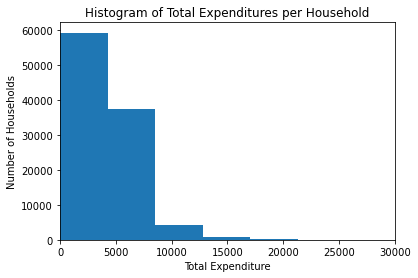

In [172]:
plt.hist(total_expenditures['total_value'],bins=50 )
plt.xlim(0,30000)
plt.title('Histogram of Total Expenditures per Household')
plt.xlabel('Total Expenditure')
plt.ylabel('Number of Households')

In [203]:
#poorer_x = reference_x/2

#Pscale = np.linspace(1,3,20).tolist()

#log_nar = {s0:np.log(nutrient_adequacy_ratio(reference_x,my_prices(s0,p,i=USE_GOOD)))[UseNutrients] for s0 in Pscale}

#log_nar = pd.DataFrame(log_nar).T

#ax = log_nar.plot(ylabel='log NAR',xlabel='Price')


#ax.axhline(0)
#ax.axvline(p[USE_GOOD])

It should be noted that our plots and analyses generated above are based on our n dataframe, which is the nutrients dataframe provided for us from the NSS data. The only nutrients included are protein, fat, and calories. To form a more complete analysis and get a better understanding of the nutritional adequacy of households in Bihar, we would like to look at other nutrients as well. We will do this by converting our food items into nutrients using FDC codes, as we have done in project 2, and (for some members our group as well) in project 3.

# Food Conversion Table & Nutritional Adequacy of Demands Part II

We found the fdc IDs of each food item in our n dataset, imported below as fdc_codes.

In [174]:
fdc_codes = pd.read_csv('proj_3_fdc_codes.csv').set_index('Item')
fdc_codes = fdc_codes.reset_index()
fdc_codes

,Item,ID
0,apple,1102644
1,arhar (tur),1977550
2,baby food,1102843
3,bajra & products,1799770
4,banana,1102653
...,...,...
90,urd,1898206
91,"vanaspati, margarine",1103828
92,walnut,2118446
93,watermelon,1102698


In [175]:
fdc_codes = fdc_codes[fdc_codes['Item'].isin(n.index)] #make sure to include items in the n dataset above
len(fdc_codes)

31

In [176]:
estimated_quantities = q_bihar_n.groupby('i').mean()
estimated_quantities = estimated_quantities[estimated_quantities.index.isin(fdc_codes['Item'])]
estimated_quantities.head()

,total_quantity,Calories,Fat,Protein,rural
i,,,,,
apple,1.318311,590.0,5.0,2.0,0.0
arhar (tur),1.568844,3350.0,17.0,223.0,0.0
besan,0.552420,3400.0,12.0,220.0,0.0
bread (bakery),0.775502,2450.0,7.0,78.0,0.0
brinjal,2.385902,240.0,3.0,14.0,0.0


In [177]:
Q = fdc_codes
#Q['Quantity'] = [1000]*len(fdc_codes)
Q['Quantity'] = estimated_quantities['total_quantity'].to_list()
Q['Quantity'] = Q['Quantity'] * 10 #convert from kg to hectograms 
Q = Q.reset_index()
Q.head() #Q is a dataframe that indicates quantities of each item in fdc_codes

/tmp/ipykernel_24/3660605760.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Q['Quantity'] = estimated_quantities['total_quantity'].to_list()
/tmp/ipykernel_24/3660605760.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Q['Quantity'] = Q['Quantity'] * 10 #convert from kg to hectograms


,index,Item,ID,Quantity
0,0,apple,1102644,13.183112
1,1,arhar (tur),1977550,15.688439
2,9,besan,2091506,5.524203
3,11,bread (bakery),1100621,7.755023
4,12,brinjal,2024758,23.859016


After matching all of the food items across the different dataframes for uniformity, we ran the following cell to produce a dataframe that has the nutritional content of each food item we're looking at. We will use the information in this dataframe to map the nutrients to the predicted consumption per household, qhat.

In [178]:
import fooddatacentral as fdc
apikey = 'CDXgPa1HVqJab8EFllem1ikOF75m2ELYwziKtICr'
D = {}
count = 0
for food in Q.Item.tolist():
    try:
        FDC = Q.loc[Q.Item==food,:].ID[count]
        count+=1
        print(FDC)
        D[food] = fdc.nutrients(apikey,FDC).Quantity
    except AttributeError: 
        warnings.warn("Couldn't find FDC Code %s for food %s." % (food,FDC))        

D = pd.DataFrame(D,dtype=float).fillna(0)

D

1102644
1977550
2091506
1100621
2024758
1103343
1103345
2029648
170497
2216557
175304
168448
1100536
1102666
1942595
2008520
2091229
2155640
172420
1100404
172337
1103364
1103153
1102879
1103374
2129576
2077766
1126152
1103276
1103828
522973


,apple,arhar (tur),besan,bread (bakery),brinjal,cabbage,cauliflower,chicken,chillis (green),french beans and barbati,...,onion,palak,potato,radish,"refined oil [sunflower, soyabean, saffola, etc.]",rice - other sources,"suji, rawa",tomato,"vanaspati, margarine",wheat/atta - other sources
Alanine,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.082,0.0,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0
"Alcohol, ethyl",0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.000,0.0,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0
Amino acids,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.000,0.0,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0
Arginine,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.096,0.0,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0
Ash,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.600,0.0,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Vitamin K (Dihydrophylloquinone),0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.000,0.0,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0
Vitamin K (phylloquinone),2.20,0.0,0.0,0.20,0.0,38.20,15.50,0.0,14.300,0.0,...,0.40,178.00,4.10,1.30,0.0,0.0,0.0,7.90,101.30,0.0
Vitamins and Other Components,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.000,0.0,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0
Water,85.56,0.0,0.0,35.70,0.0,90.39,92.07,0.0,87.740,0.0,...,89.11,82.03,72.09,95.27,0.0,0.0,0.0,94.52,37.58,0.0


In [179]:
qhat = pd.read_csv('qhat_bihar.csv')
qhat = qhat.set_index(['t', 'm', 'j'])
qhat.head()

apple  arhar (tur)  banana       besan  \
t m j                                                         
1 1 470441101  2639.995325  1659.125400     NaN  726.465664   
    470441102  1042.342338  1136.653880     NaN  448.704296   
    470441201  1047.269911  1482.081243     NaN  636.119070   
    470441202  1368.947645  1495.042945     NaN  627.090476   
    470441203  1178.226715  1569.226732     NaN  536.378372   

               biscuits, chocolates  black pepper  bread (bakery)  \
t m j                                                               
1 1 470441101                   NaN           NaN      640.673689   
    470441102                   NaN           NaN      520.619697   
    470441201                   NaN           NaN      722.342601   
    470441202                   NaN           NaN      670.925393   
    470441203                   NaN           NaN      566.039238   

                   brinjal      cabbage  cake, pastry, prepared sweets  ...  \
t m j                                                                   ...   
1 1 470441101  2804.504727  3002.372978                            NaN  ...   
    470441102  1903.614296  2050.762277                            NaN  ...   
    470441201  2724.921981  3024.971187                            NaN  ...   
    470441202  2597.196392  2752.571949                            NaN  ...   
    470441203  2397.189358  2426.329423                            NaN  ...   

               sewai, noodles  sugar - other sources  suji, rawa  tea : cups  \
t m j                                                                          
1 1 470441101      646.271095            3484.198321  913.260804         NaN   
    470441102      451.076979            1976.960460  591.110329         NaN   
    470441201      501.180769            3182.126511  812.989933         NaN   
    470441202      580.936474            3083.668613  799.348157         NaN   
    470441203      508.116536            3047.975725  716.216142         NaN   

               tea : leaf       tomato  turmeric  vanaspati, margarine  \
t m j                                                                    
1 1 470441101         NaN  2807.114109       NaN            695.123155   
    470441102         NaN  1435.139514       NaN            364.110379   
    470441201         NaN  1850.249515       NaN            493.759679   
    470441202         NaN  2171.984762       NaN            521.776751   
    470441203         NaN  1757.453362       NaN            557.292136   

               wheat/atta - P.D.S.  wheat/atta - other sources  
t m j                                                           
1 1 470441101         10352.186018                23221.854219  
    470441102          9155.209342                17634.644634  
    470441201         10389.639345                34192.794413  
    470441202         10814.960997                28368.361167  
    470441203         10384.087530                30632.773950  

[5 rows x 82 columns]

In [180]:
food_list = qhat.columns.values.tolist()
d_list = D.columns.values.tolist()

#cross filter and match the two dfs; replace NaN values with 0 
final_q = qhat.filter(items=d_list).replace(np.nan,0)/30 #convert monthly predicted intak to daily 
final_d = D.filter(items=food_list).replace(np.nan,0)

In [181]:
actual_mean_consumption = final_q@final_d.T 
actual_mean_consumption = actual_mean_consumption.rename(columns={'Calcium, Ca': 'Calcium', 'Iron, Fe': 'Iron', 'Energy': 'Calories', 'Carotene, beta': 'Betacarotene', 
                               'Total lipid (fat)': 'Fat', 'Thiamin': 'Thiamine', 'Vitamin C, total ascorbic acid': 'Ascorbic Acid'
                              
                              })
actual_mean_consumption = actual_mean_consumption.mean(axis=0)
actual_mean_consumption

Alanine                                58.997194
Alcohol, ethyl                          0.000000
Amino acids                             0.000000
Arginine                              174.002802
Ash                                   272.477552
                                        ...     
Vitamin K (Dihydrophylloquinone)        0.000000
Vitamin K (phylloquinone)           23504.903431
Vitamins and Other Components           0.000000
Water                               92990.432839
Zinc, Zn                              692.980748
Length: 114, dtype: float64

In [182]:
transposed_D = D.T

In [183]:
D_corrected_labels = transposed_D.rename(columns={'Calcium, Ca': 'Calcium', 'Iron, Fe': 'Iron', 'Energy': 'Calories', 'Carotene, beta': 'Betacarotene', 
                               'Total lipid (fat)': 'Fat', 'Thiamin': 'Thiamine', 'Vitamin C, total ascorbic acid': 'Ascorbic Acid'
                              
                              })
D_corrected_labels = D_corrected_labels[['Calcium', 'Iron', 'Calories', 'Betacarotene', 'Fat', 'Thiamine', 'Ascorbic Acid', 'Riboflavin', 'Niacin', 'Protein']]
D_corrected_labels

,Calcium,Iron,Calories,Betacarotene,Fat,Thiamine,Ascorbic Acid,Riboflavin,Niacin,Protein
apple,6.0,0.12,52.0,27.0,0.17,0.017,4.6,0.026,0.091,0.26
arhar (tur),20.0,1.33,100.0,0.0,3.33,0.000,0.0,0.000,0.000,4.00
besan,45.0,4.00,407.0,0.0,0.00,0.000,4.8,0.000,0.000,22.00
bread (bakery),211.0,3.36,270.0,0.0,3.59,0.507,0.0,0.240,4.760,9.43
brinjal,0.0,0.00,333.0,0.0,23.33,0.000,0.0,0.000,0.000,0.00
cabbage,45.0,0.80,31.0,670.0,0.16,0.064,57.0,0.069,0.418,1.43
cauliflower,22.0,0.42,25.0,0.0,0.28,0.050,48.2,0.060,0.507,1.92
chicken,0.0,0.00,167.0,0.0,0.00,0.000,0.0,0.000,0.000,6.67
chillis (green),18.0,1.20,167.0,671.0,0.20,0.090,242.5,0.090,0.950,2.00
french beans and barbati,35.0,1.06,29.0,0.0,0.00,0.000,0.0,0.000,0.000,2.35


In [184]:
import warnings 

def other_nutrient_demand(x,p): 
    with warnings.catch_warnings(): #gets rids of messy warnings
        warnings.simplefilter("ignore")
        c = r.demands(x,p) #compute quantities demand for all food (predicted, positive levels for every good)
    

    n0,c0 = D_corrected_labels.align(c,axis=0,join='inner') #alignment trick
    
    N = n0.T@c0 #takes quantities demand (c0) and multiplies by fct0

    N = N.loc[~N.index.duplicated()]
    #Calcium, Iron, Thiamin, Riboflavin, Protein, 
    
    return N

In [185]:
xbar = r.get_predicted_expenditures().sum('i')
median_x = xbar.where(xbar>0).sel().median('j') # Budget (median household)
median_x

<xarray.DataArray (t: 1, m: 1)>
array([[6121.22713493]])
Coordinates:
  * m        (m) int64 1
  * t        (t) int64 1

In [186]:
other_nutrient_demand(median_x, p) #prediction of how much households are consuming at median_x 

Calcium          7.605482e+05
Iron             2.943263e+04
Calories         6.171341e+06
Betacarotene     2.658887e+06
Fat              2.024945e+05
Thiamine         3.083386e+03
Ascorbic Acid    3.458934e+05
Riboflavin       2.084672e+03
Niacin           4.523802e+04
Protein          1.378090e+05
dtype: float64

In [187]:
(actual_mean_consumption/other_nutrient_demand(median_x, p)).dropna() #calculating magnitudes to adjust by

Ascorbic Acid    0.087450
Betacarotene     0.206090
Calcium          0.042887
Calories         0.206202
Fat              0.087917
Iron             0.293624
Niacin           0.229048
Protein          0.179510
Riboflavin       0.090574
Thiamine         0.045203
dtype: float64

Text(0, 0.5, 'log nutrient')

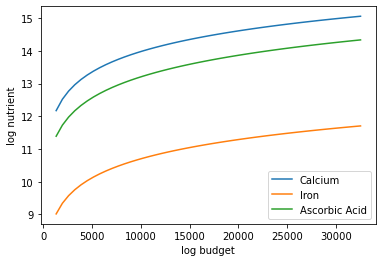

In [188]:
import numpy as np
import matplotlib.pyplot as plt

X = np.linspace(reference_x/5,reference_x*5,50)
X = X.flatten()

UseNutrients = ['Calcium', 'Iron', 'Ascorbic Acid']

df = pd.concat({myx:np.log(other_nutrient_demand(myx,p))[UseNutrients] for myx in X},axis=1).T
ax = df.plot()

ax.set_xlabel('log budget') 
ax.set_ylabel('log nutrient')

Text(0, 0.5, 'log nutrient')

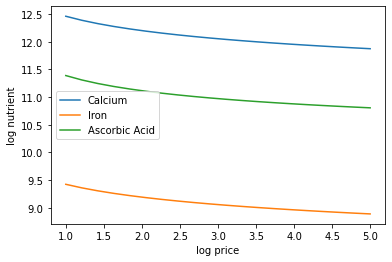

In [189]:
USE_GOOD = "apple"

ref_price = r.prices.sel(i=USE_GOOD,m=m,drop=True)

P = np.linspace(1,5,20).tolist()

ndf = pd.DataFrame({p0:np.log(other_nutrient_demand(reference_x,my_prices(p0,i=USE_GOOD)))[UseNutrients] for p0 in P}).T

ax = ndf.plot()

ax.set_xlabel('log price')
ax.set_ylabel('log nutrient') 

Text(0, 0.5, 'log nutrient')

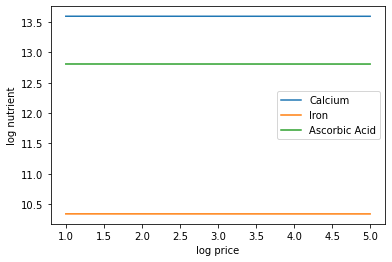

In [190]:
USE_GOOD = "rice - P.D.S."

ref_price = r.prices.sel(i=USE_GOOD,m=m,drop=True)

P = np.linspace(1,5,20).tolist()

ndf = pd.DataFrame({p0:np.log(other_nutrient_demand(reference_x,my_prices(p0,i=USE_GOOD)))[UseNutrients] for p0 in P}).T

ax = ndf.plot()

ax.set_xlabel('log price')
ax.set_ylabel('log nutrient') 

In [191]:
def other_nutrient_adequacy_ratio(x,p):
    return other_nutrient_demand(x,p)/hh_rda #greater than 1 = adequate, less than 1 = less than adequate bc log of ratios

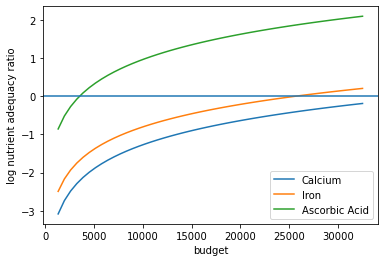

In [192]:
X = np.linspace(reference_x/5,reference_x*5,50)
X = X.flatten()
ndf = pd.concat({x:np.log(other_nutrient_adequacy_ratio(x,p))[UseNutrients] for x in X},axis=1).T

ax = (ndf-np.log(1000)).plot() #temporary fix

ax.set_xlabel('budget')
ax.set_ylabel('log nutrient adequacy ratio')
ax.axhline(0)


Note for code reviewers: we are double-checking some of our units to make sure that this plot isn't too skewed.

In [204]:
#poorer_x = reference_x/2

#Pscale = np.linspace(1,3,20).tolist()

#log_nar = {s0:np.log(other_nutrient_adequacy_ratio(reference_x,my_prices(s0,p,i=USE_GOOD)))[UseNutrients] for s0 in Pscale}

#log_nar = pd.DataFrame(log_nar).T

#ax = log_nar.plot(ylabel='log NAR',xlabel='Price')


#ax.axhline(0)
#ax.axvline(p[USE_GOOD])

# Policy Changes

### Ceteris Paribus

In [212]:
import numpy as np

### First year, first market, and some good.  Change if you wish! ###
my_m = r.coords['m'].data.flatten()[0] # Market
my_i = 'apple' # r.coords['i'].data.flatten()[0] # Good
#####################################################################

p = r.prices.sel(variable=1,m=my_m,drop=True)
phat = p.to_dataframe('i').dropna().squeeze()

ref_price = r.prices.sel(i=my_i,m=my_m)
P = np.linspace(ref_price/10,ref_price*5,50)

def my_prices(p0,p=phat,i=my_i):
    """
    Set price of good i to p0, holding remaining prices fixed at values in p.
    """
    p = p.copy()
    p.loc[i] = p0
    return p.squeeze()

phat

i
apple                                               0.075035
arhar (tur)                                         0.075512
besan                                               0.060223
bread (bakery)                                      0.049760
brinjal                                             0.014824
cabbage                                             0.010304
cauliflower                                         0.012188
chicken                                             0.121698
chillis (green)                                     0.046695
chira                                               0.024698
firewood & chips                                    0.005032
fish ( fresh )                                      0.107222
french beans and barbati                            0.018852
goat meat                                           0.256172
gourd, pumpkin                                      0.009991
gram (split)                                        0.055219
gram (whole)          

### Simple Policy Experiments: Changing Budget

In [213]:
# A quantile of 0.5 is the median.  Play with quantile value, or just assign.
xbar = r.get_predicted_expenditures().sel(m=my_m).sum('i')

# Drop households with /no/ predicted expenditures
xbar = xbar.where(xbar>0)

x0 = xbar.quantile(0.5,'j') # Budget (median household)
#x0 = 50


# Range of budgets to explore
X = np.linspace(x0/10,x0*5,50)

### Simple Policy Experiments: Changing Prices

#### Marshallian vs. Hicksian Demand Curves


/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings

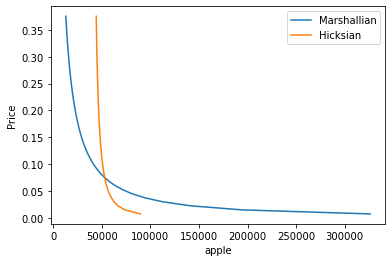

In [214]:
test = P.flatten()

import matplotlib.pyplot as plt

#my_i = 'apple'   # Interesting Ugandan staple

U0 = r.indirect_utility(x0,p)

plt.plot([r.demands(x0,my_prices(p0,i=my_i))[my_i] for p0 in P],P)
plt.plot([r.demands(U0,my_prices(p0,i=my_i),type="Hicksian")[my_i] for p0 in P],P)
plt.ylabel('Price')
plt.xlabel(my_i)
# plt.axhline(p.sel(i=my_i).values)
plt.legend(("Marshallian","Hicksian"))

/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings

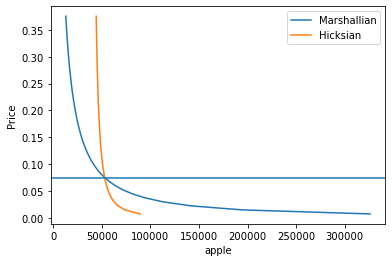

In [197]:
import matplotlib.pyplot as plt

my_i = 'apple'  # Interesting Ugandan staple

U0 = r.indirect_utility(x0,p)

plt.plot([r.demands(x0,my_prices(p0,i=my_i))[my_i] for p0 in P],P)
plt.plot([r.demands(U0,my_prices(p0,i=my_i),type="Hicksian")[my_i] for p0 in P],P)
plt.ylabel('Price')
plt.xlabel(my_i)
plt.axhline(p.sel(i=my_i).values)
plt.legend(("Marshallian","Hicksian"))

#### Welfare measures

In [198]:
def compensating_variation(U0,p0,p1):
    x0 = r.expenditure(U0,p0)
    x1 = r.expenditure(U0,p1)

    return x1-x0

def revenue(U0,p0,p1,type='Marshallian'):
    """(Un)Compensated revenue from taxes changing vector of prices from p0 to p1.

    Note that this is only for *demand* side (i.e., if supply perfectly elastic).
    """
    
    dp = p1 - p0 # Change in prices

    c = r.demands(U0,p1,type=type)

    dp,c = dp.align(c,join='inner')

    return dp.T@c


def deadweight_loss(U0,p0,p1):
    """
    Deadweight loss of tax/subsidy scheme creating wedge in prices from p0 to p1.

    Note that this is only for *demand* side (i.e., if supply perfectly elastic).
    """
    cv = compensating_variation(U0,p0,p1)

    return cv - revenue(U0,p0,p1,type='Hicksian') 
    
    
def compensated_nutrient_demand(U,p,z=None):
    c = r.demands(U,p,z=z,type='Hicksian')
    fct0,c0 = fct.align(c,axis=0,join='inner')
    N = fct0.T@c0

    return N

def compensated_nutrient_adequacy_ratio(U,p):
    return (compensated_nutrient_demand(U,p)/hh_rdi.T).squeeze()

#### Price Changes, Revenue, and Compensating Variation

With these changes in prices for a few food items, we can visualize the compensation variation-- the amount of money one would have to give a consumer to offset completely the harm from a price increase in order to keep the consumer on the original indifference curve. In our policy, we would essentially decrease the price of food items rich in the nutrients necessary for an adequate diet and give money to the consumer to fully compensate them.

/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings

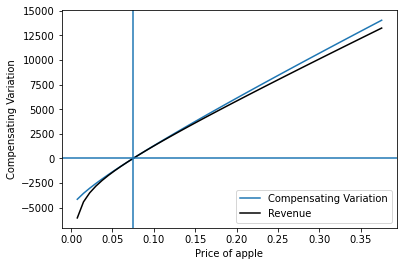

In [199]:
fig, ax1 = plt.subplots()

ax1.plot(P,[compensating_variation(U0,phat,my_prices(p0,i=my_i)) for p0 in P])
ax1.set_xlabel("Price of %s" % my_i)
ax1.set_ylabel("Compensating Variation")

ax1.plot(P,[revenue(U0,phat,my_prices(p0,i=my_i),type='Hicksian') for p0 in P],'k')
ax1.legend(('Compensating Variation','Revenue'))
ax1.axhline(0)
ax1.axvline(phat.loc[my_i])

#### Deadweight Loss


/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings

Text(0, 0.5, 'Deadweight Loss')

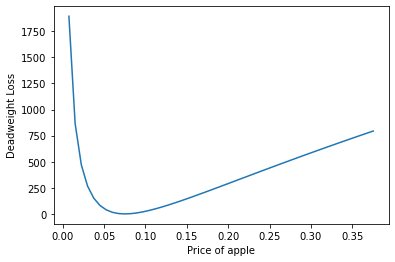

In [215]:
fig, ax1 = plt.subplots()

ax1.plot(P,[deadweight_loss(U0,phat,my_prices(p0,i=my_i)) for p0 in P])
ax1.set_xlabel("Price of %s" % my_i)
ax1.set_ylabel("Deadweight Loss")